# Street Label Points Example

This real-world example demonstrates how to derive label points for labeling streets in our reports.

## Examining the inputs

We will use three datasets to derive points for labeling streets in our reports: `physical_blocks`, `physical_block_lines` and `city_streets`. The `physical_block_lines` layer represents the edges of our physical blocks and the `city_streets` layer contains street centerline geometries from NYC Department of City Planning.

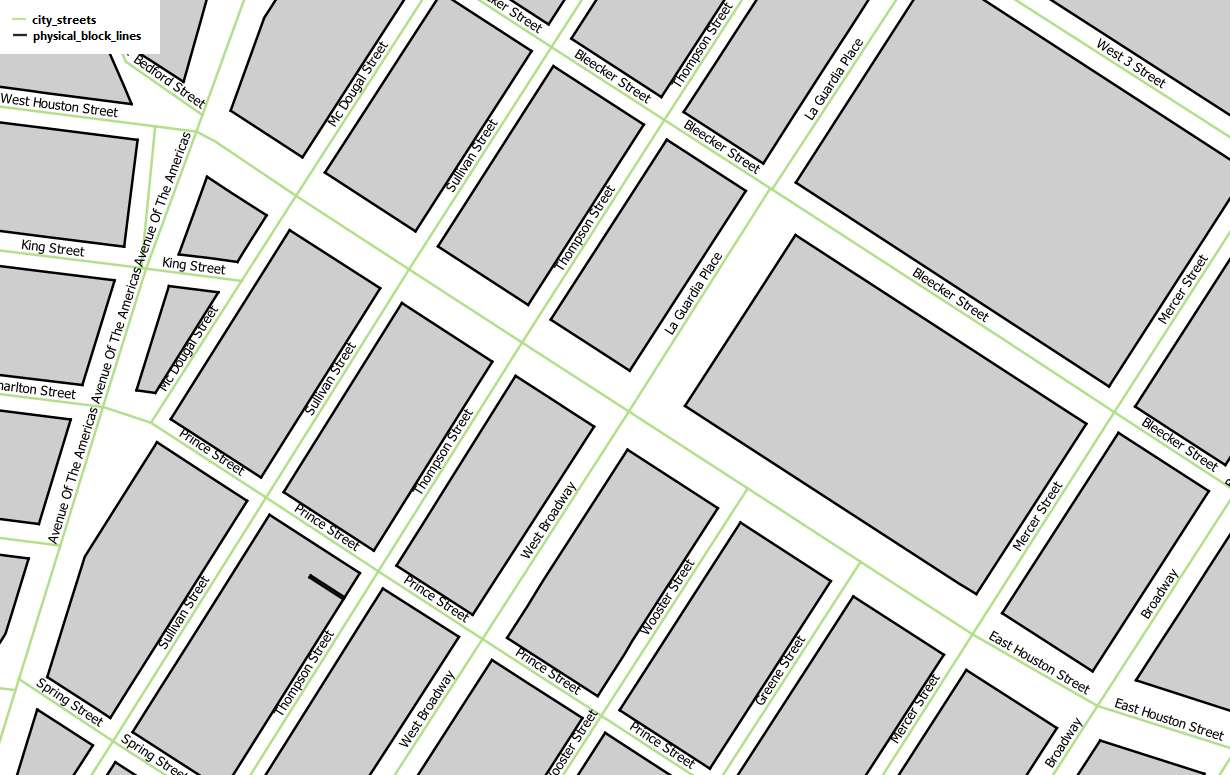

We will use the midpoints of each block edge to derive points for labeling the streets that surround each block. We can also derive the name of the street and the proper orientation for the text when displayed in the report. 

## Importing the required libraries

In this example we will need access to the `Workspace()`, `Layer()` and `Line()` objects from the Models API. We'll also import a useful function for converting list into SQL `IN` clauses.

In [1]:
from envelopegis.models.workspace import Workspace
from envelopegis.models.layer import Layer
from envelopegis.models.line import Line
from envelopegis.utils.database import create_in_clause

## Set up a working geodatabase

It's a good practice to create a new geodatabase for processing data to insure that no unintended changes occur in the production dataset. In the code below, we will create a new working geodatabase and copy the two feature classes we need into the database.

Text(0.5, 1.0, 'Loaded 1 block polygon \nLoaded 4 block edges \nLoaded 12 street centerlines')

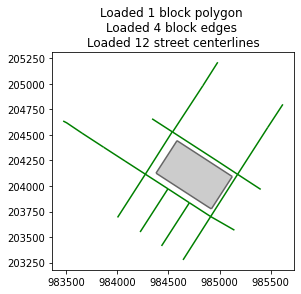

In [2]:
# create a working geodatabase called 'street_label_processing'
working_credentials = {
    'host': 'gisbox.ehq',
    'port': 7602,
    'user': 'postgres',
    'password': ''
}
workspace = Workspace.create_geodatabase(working_credentials, 'street_label_processing')

# connect to the source geodatabase and load up the required layers
source_credentials = {
    'host': 'gisbox.ehq',
    'port': 7601,
    'database': 'inputs',
    'user': 'postgres',
    'password': ''
}
source_workspace = Workspace(source_credentials)
physical_blocks_layer = Layer('physical_blocks', source_workspace)
physical_block_lines_layer = Layer('physical_block_lines', source_workspace)
city_streets_layer = Layer('city_streets', source_workspace)

# for this example, we'll only copy block data for one block, 
# and city streets that are within 250 feet of the block
physical_blocks_layer.select_layer_by_attribute("PhyBlockId = 'NY-MN-524'")
physical_block_lines_layer.select_layer_by_attribute("PhyBlockId = 'NY-MN-524'")
city_streets_layer.select_layer_by_location('WITHIN_A_DISTANCE', physical_blocks_layer, search_distance=250)


# now copy the selected data over to the working database
city_streets_layer = city_streets_layer.copy_to_new_table('city_streets', workspace)
physical_block_lines_layer = physical_block_lines_layer.copy_to_new_table('physical_block_lines', workspace)
physical_blocks_layer = physical_blocks_layer.copy_to_new_table('physical_blocks', workspace)


# plot the geometries
ax = city_streets_layer.plot(color='green')
physical_block_lines_layer.plot(ax=ax, color='0.4')
physical_blocks_layer.plot(ax=ax, color='0.8')
ax.set_title('Loaded {} block polygon \nLoaded {} block edges \nLoaded {} street centerlines'.format(
    physical_blocks_layer.count, physical_block_lines_layer.count, city_streets_layer.count))

## Collecting the block edge midpoints

We'll begin our analysis by collecting some information about the edges of the block. For each edge we'll gather the block id and geometry for the edge, and we'll also take advantage of properties on the `Line()` object to collect the midpoint of each edge.

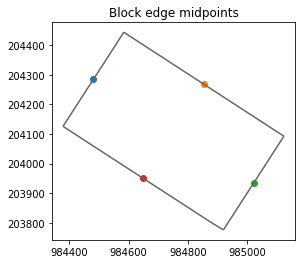

In [3]:
# collect the physical block id, line object, and midpoint for each block edge
with physical_block_lines_layer.get_search_cursor(['PhyBlockId', physical_block_lines_layer.shape]) as cursor:
    block_edges = [{
        'phy_block_id': row['PhyBlockId'], 
        'line': row[physical_block_lines_layer.shape], 
        'midpoint': row[physical_block_lines_layer.shape].midpoint
    } for row in cursor]
    
# plot the midpoints
ax = physical_block_lines_layer.plot(color='0.4')
ax.set_title('Block edge midpoints')
for block_edge in block_edges:
    block_edge['midpoint'].plot(ax=ax, marker='o')

## Collecting the physical block polygons

We'll need easy access to the geometry of each physical block for our analysis, so we'll collect them in a dictionary keyed on their physical block ids. 

In [4]:
with physical_blocks_layer.get_search_cursor(['PhyBlockId', physical_blocks_layer.shape]) as cursor:
    block_polygons = {row['PhyBlockId']: row[physical_blocks_layer.shape] for row in cursor} 

## Finding target street edges

Now that we have the midpoint of each block edge, we'll use those points to find the nearest street centerline to each edge. There are two important considerations when selecting the target street edge:

1. The target edge should be parallel to the block edge (it is possible that the nearest street edge might be a side street that is perpendicular to the block edge - these edges should not be selected)
2. The target edge should not be on the other side of the block (it is possible that the nearest street edge is on the opposite side of the block - these edges should not be selected)

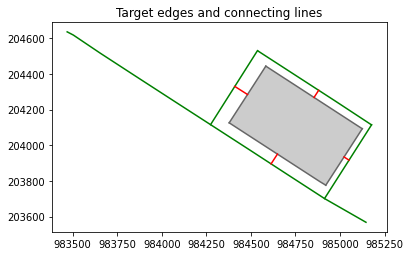

In [5]:
# loop through each block edge and find a target street edge
# based on the midpoint of the block edge
for block_edge in block_edges:
    # clear any selections in the city street layer left
    # over from previous loops
    city_streets_layer.clear_selection()
    
    # grab the block polygon for this block
    block_polygon = block_polygons[block_edge['phy_block_id']]
    
    # set a flag marking that we have not found the target
    target_found = False
    
    # initialize a list of ruled-out edges
    ruled_out_oids = []
    
    # loop unti we find a proper target
    while not target_found:
        # find the nearest street to the midpoint of our block edge
        nearest_oid, nearest_line = city_streets_layer.nearest_item(block_edge['midpoint'])
        
        # if nearest oid is -1, we couldn't find a near shape
        if nearest_oid == -1:
            break
        
        # let's check to see if the street edge is parallel to
        # the block edge - if not rule this line out
        if not nearest_line.is_parallel(block_edge['line']):
            # add the oid to the list of ruled-out oids
            ruled_out_oids.append(nearest_oid)
            
            # create an "OBJECTID NOT IN" clause and select
            # the streets that have not been ruled out
            not_in_clause = create_in_clause(ruled_out_oids, field_name=city_streets_layer.oid, not_operator=True)
            city_streets_layer.select_layer_by_attribute(not_in_clause)
            # move to the next potential target
            continue
            
        
        # if we make it here this street edge is still a potential target
        
        # let's check to see if the street edge is on the wrong 
        # side of the block by creating a line connecting the edges
        nearest_point_on_street = nearest_line.nearest_point(block_edge['midpoint'])
        connecting_line = Line([nearest_point_on_street, block_edge['midpoint']], nearest_line.spatial_reference)
        
        # if the connecting line crosses the physical block polygon,
        # the street edge is on the wrong side of the block
        if block_polygon.contains(connecting_line.midpoint):
            # as before, rule out this oid and move to the next potential target
            ruled_out_oids.append(nearest_oid)
            not_in_clause = create_in_clause(ruled_out_oids, field_name=city_streets_layer.oid, not_operator=True)
            city_streets_layer.select_layer_by_attribute(not_in_clause)
            continue
        
        # if we make it here, this is our target!
        
        # first, use the near oid to query the street name out of the table
        city_streets_layer.select_layer_by_attribute(nearest_oid)
        with city_streets_layer.get_search_cursor('official_s') as street_cursor:
            street_name = next(street_cursor)['official_s']
        
        # now append the new info to the edge dictionary and move on
        block_edge['street_name'] = street_name
        block_edge['target_edge'] = nearest_line
        block_edge['connecting_line'] = connecting_line
        target_found = True
        
# once we complete the loop above, each block edge should have a 
# street name, target edge, and connecting line

# let's plot the data
ax = physical_blocks_layer.plot(color='0.8')
ax.set_title('Target edges and connecting lines')
for block_edge in block_edges:
    block_edge['line'].plot(ax=ax, color='0.4')
    block_edge['target_edge'].plot(ax=ax, color='green')
    block_edge['connecting_line'].plot(ax=ax, color='red')


## Finding street name label points

Now that we have established target information for each block edge, we can determine label points for labeling street names in our reports. The primary consideration is that in the report view we want all label points to be the same distance from the edge of the block. 

The simplest way to do this is to find the length of the shortest connecting line and make that distance the distance from the block edge that the label point will be placed. We can then find a point along each of the longer connecting lines that is at the correct distance from the block edge.

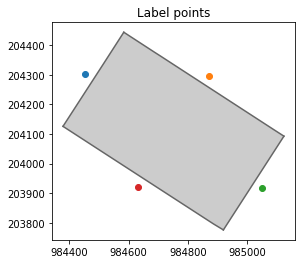

In [6]:
# first, let's find the length of the shortest connecting line
shortest_edge = sorted(block_edges, key=lambda x: x['connecting_line'].length)[0]
shortest_length = shortest_edge['connecting_line'].length

# now for each block edge we'll find a point along its connecting line at the specified distance
for block_edge in block_edges:
    # the connecting lines are oriented so that they point towards the block,
    # so we need to invert the distance for each line
    point_distance = block_edge['connecting_line'].length - shortest_length
    
    # find the point along the connecting line to be the label point
    block_edge['label_point'] = block_edge['connecting_line'].point_at_distance(point_distance)
    
# let's plot the data
ax = physical_blocks_layer.plot(color='0.8')
ax.set_title('Label points')
for block_edge in block_edges:
    block_edge['line'].plot(ax=ax, color='0.4')
    block_edge['label_point'].plot(ax=ax, marker='o')

## Finding text orientation for street name labels

Now that we have locations for placing labels, let's determine the text orientations for each label. For this calculation we'll assume that the default orientation for report drawing is north, and we'll calculate the best rotation angles for each label based on this assumption. If the drawing is rotated within the report, the label angles can be recalculated on the fly by determining the amount of rotation from north and adjusting the label angles accordingly.

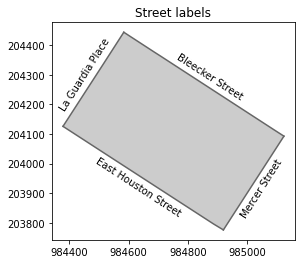

In [7]:
# we'll collect two angles for each label, its bearing (compass) angle
# and its theta angle (useful for orienting in some application)
for block_edge in block_edges:
    # if the connecting line points "down", invert the angles
    if 90 < block_edge['connecting_line'].endpoints_angle < 270:
        block_edge['bearing'] = block_edge['connecting_line'].endpoints_angle + 180
        if block_edge['bearing'] >= 360:
            block_edge['bearing'] = block_edge['bearing'] - 360
        block_edge['theta'] = block_edge['connecting_line'].endpoints_theta + 90
    else:
        block_edge['bearing'] = block_edge['connecting_line'].endpoints_angle
        block_edge['theta'] = block_edge['connecting_line'].endpoints_theta - 90

# now plot the labels
ax = physical_blocks_layer.plot(color='0.8')
ax.set_title('Street labels')
for block_edge in block_edges:
    block_edge['line'].plot(ax=ax, color='0.4')
    ax.annotate(
        text=block_edge['street_name'],
        xy=(block_edge['label_point'].x, block_edge['label_point'].y),
        va='center', ha='center',
        rotation=block_edge['theta']
    )


## Storing the outputs

Now that we've calculated the street label points and their rotations, we can store these outputs for future use.

In [8]:
# create a layer called "street_labels" and
# add some appropriate attributes
outputs_layer = workspace.create_feature_class('street_labels', 'POINT', spatial_reference=physical_blocks_layer.spatial_reference)
outputs_layer.add_field('phyBlockId', 'TEXT', field_length=700)
outputs_layer.add_field('street', 'TEXT', field_length=300)
outputs_layer.add_field('bearing', 'FLOAT')
outputs_layer.add_field('theta', 'FLOAT')

# now turn the data we collected into new rows
# for the table and insert them
new_rows = [{
    'phyBlockId': block_edge['phy_block_id'],
    'street': block_edge['street_name'],
    'bearing': block_edge['bearing'],
    'theta': block_edge['theta'],
    outputs_layer.shape: block_edge['label_point']
} for block_edge in block_edges]
outputs_layer.add_rows(new_rows)

print('Added {} rows to table'.format(outputs_layer.count))

Added 4 rows to table


## Examining the output table

Now that we have stored our analyzed data we can consider how it can be integrated into other processes. Below are the contents of the new `street_labels` table. Notice that the `bearing` angle indicates the "upward" angle for the text, and is based on "compass bearing" degrees. The `theta` angle is based on the plane that the text rest on, and is expressed as a vector angle.

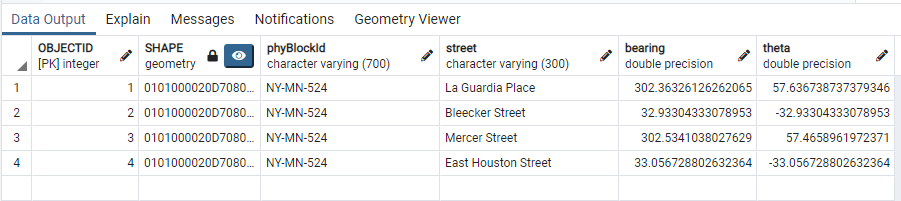

Applications that want to use the `street_labels` table should query it using the `phyBlockId` field. Many layers, such as `primary_lots`, `sublot_lines`, and `city_blocks` all maintain a `phyBlockId` field, so accessing it for a given lot or block should be simple. Once the block id of interest has been identified, finding the blocks label points can be done with a simple query.

```sql
SELECT "street", "bearing", "theta", "SHAPE"
FROM street_labels
WHERE "phyBlockId" = {selected_id}

```